In [1]:
import pandas as pd
import numpy as np

# DIY Spotify Wrapped 2022

As a long-time Spotify Premium subscriber and an avid listener of the "Made For You" playlists (created by Spotify to "help you discover more of what you love"), I have always been curious about the metrics used to determine what I may like. I have also been curious about whether my Spotify Wrapped provided at the end of each year is accurate.

To dig into this idea, I used data both provided by Spotify and downloaded by Spotify’s API about my account to see what songs/artists dominate my streaming history, when I listen the most, whether there are any common audio features, and more!

### Import Streaming History Data

This first section is using my account data found [here](https://www.spotify.com/us/account/privacy/). The turnaround time for this request took around ~5 days. I received a `.zip` folder with different files about my playlists, search queries, payment, followers/following accounts, stream history, etc. from the last 12 months. For this project, I am going to be focusing on the latter (stream history).

In [2]:
sm0 = pd.read_json('StreamingHistory0.json')
sm1 = pd.read_json('StreamingHistory1.json')
sm2 = pd.read_json('StreamingHistory2.json')

I recieved 3 `.json` files of streaming history because there is a max of 10,000 rows per file. Used a `for` loop to append each file to one large DataFrame.

In [3]:
list = [sm0, sm1, sm2]

streams = pd.DataFrame()

for df in list:
    streams = streams.append(df, ignore_index=True)

C:\Users\chery\AppData\Local\Temp\ipykernel_12360\4046198382.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  streams = streams.append(df, ignore_index=True)


In [4]:
streams.head()

,endTime,artistName,trackName,msPlayed
0,2021-11-25 01:08,Grouplove,Deleter - ayokay Remix,533
1,2021-11-29 15:12,$uicideboy$,Materialism as a Means to an End,133514
2,2021-11-30 00:19,$uicideboy$,Materialism as a Means to an End,32743
3,2021-11-30 00:21,BONES,Sodium,115392
4,2021-11-30 00:22,BONES,AirplaneMode,16469


In [5]:
streams.shape

(28655, 4)

In [6]:
streams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28655 entries, 0 to 28654
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   endTime     28655 non-null  object
 1   artistName  28655 non-null  object
 2   trackName   28655 non-null  object
 3   msPlayed    28655 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 895.6+ KB


### Streaming History Data Cleaning

Looking at Spotify's documentation to [Understanding My Data](https://support.spotify.com/us/article/understanding-my-data/), the DataFrame contains the following:

    A list of items (e.g. songs, videos, and podcasts) listened to or watched in the past year, including:

        - Date and time of when the stream ended in UTC format (Coordinated Universal Time zone).
        - Name of "creator" for each stream (e.g. the artist name if a music track).
        - Name of items listened to or watched (e.g. title of music track or name of video).
        - “msPlayed”- Stands for how many mili-seconds the track was listened to.

Converted the `endTime` column to datetime format, then created new columns called `day`, `time`, and `day_week` using this information. Created a new column called `minutes_played` which converts `msPlayed` from milliseconds to minutes. Renamed columns to a more readable format.  

In [7]:
streams['endTime'] = pd.to_datetime(streams['endTime'])
streams['day'] = [d.date() for d in streams['endTime']]
streams['time'] = [d.time() for d in streams['endTime']]
streams['day_week'] = pd.DatetimeIndex(streams['endTime']).day_name()

streams['minutes_played'] = streams['msPlayed'].divide(60000)
streams = streams.drop(['msPlayed'], axis=1)

In [8]:
streams = streams.rename(columns={'endTime': 'end_time', 'artistName': 'artist_name', 'trackName' : 'track_name'})

In [9]:
# streams['artist_name'] = streams['artist_name'].str.replace('𝑢𝑖𝑐𝑖𝑑𝑒𝑏𝑜𝑦', '$uicideboy$')

In [10]:
streams.head()

,end_time,artist_name,track_name,day,time,day_week,minutes_played
0,2021-11-25 01:08:00,Grouplove,Deleter - ayokay Remix,2021-11-25,01:08:00,Thursday,0.008883
1,2021-11-29 15:12:00,$uicideboy$,Materialism as a Means to an End,2021-11-29,15:12:00,Monday,2.225233
2,2021-11-30 00:19:00,$uicideboy$,Materialism as a Means to an End,2021-11-30,00:19:00,Tuesday,0.545717
3,2021-11-30 00:21:00,BONES,Sodium,2021-11-30,00:21:00,Tuesday,1.923200
4,2021-11-30 00:22:00,BONES,AirplaneMode,2021-11-30,00:22:00,Tuesday,0.274483


### Streaming History Data Analysis

In [11]:
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go

init_notebook_mode(connected=True)

What were my most listened to artists based on the number of different tracks I listened to?

In [12]:
artists_by_count = streams.groupby('artist_name')['track_name'].count().sort_values(ascending=False).head(10)

artists_by_count.head()

artist_name
$uicideboy$    1979
Mac Miller     1696
Pouya          1387
Ghostemane     1305
BONES           763
Name: track_name, dtype: int64

In [13]:
layout = go.Layout(
    yaxis = dict(
        zerolinewidth = 1,
        ticklen = 5,
        gridwidth = 2))

go.Figure(data = [go.Bar(x = artists_by_count.index,
                             y = artists_by_count)])

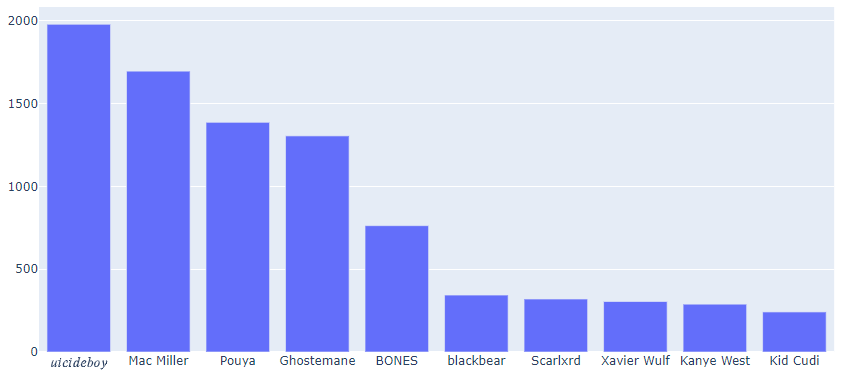

What were my most listened to artists based on the number of minutes listened to?

Dang! Looks like I spent a lot of time listening to Karen and Georgia in their show, My Favorite Murder. Although the sum of minutes listened to greatly exceeded my second most listened to artist, they only accounted for 14.29% of my total minutes listening on the Spotify platform.

In [14]:
artist_by_time = round(streams.groupby('artist_name')['minutes_played'].sum().sort_values(ascending=False), 2).head(10)

artist_by_time.head()

artist_name
My Favorite Murder with Karen Kilgariff and Georgia Hardstark    4394.67
Mile Higher                                                      2454.66
$uicideboy$                                                      1837.30
Pouya                                                            1592.75
Mac Miller                                                       1391.68
Name: minutes_played, dtype: float64

In [15]:
#percent of MFM

round(((streams['minutes_played'][streams['artist_name'] == 'My Favorite Murder with Karen Kilgariff and Georgia Hardstark'].sum() / streams['minutes_played'].sum()) * 100), 2)

14.29

In [16]:
layout = go.Layout(
    yaxis = dict(
        zerolinewidth = 1,
        ticklen = 5,
        gridwidth = 2))

go.Figure(data = [go.Bar(x = artist_by_time.index,
                             y = artist_by_time)])

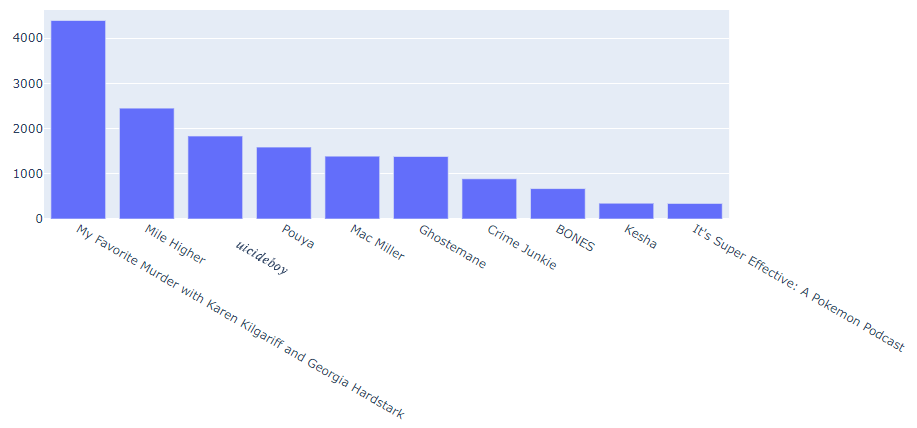

How did my total minutes listening to Spotify look over the last year?

In [17]:
minutes_by_day = streams.groupby('day', as_index=False).sum()

minutes_by_day.head()

,day,minutes_played
0,2021-11-25,0.008883
1,2021-11-29,2.225233
2,2021-11-30,93.826000
3,2021-12-01,344.829250
4,2021-12-02,53.113167


In [18]:
px.line(minutes_by_day, x = 'day', y = 'minutes_played',
              labels={
                     'day' : 'Month',
                     'minutes_played' : 'Minutes Played'})

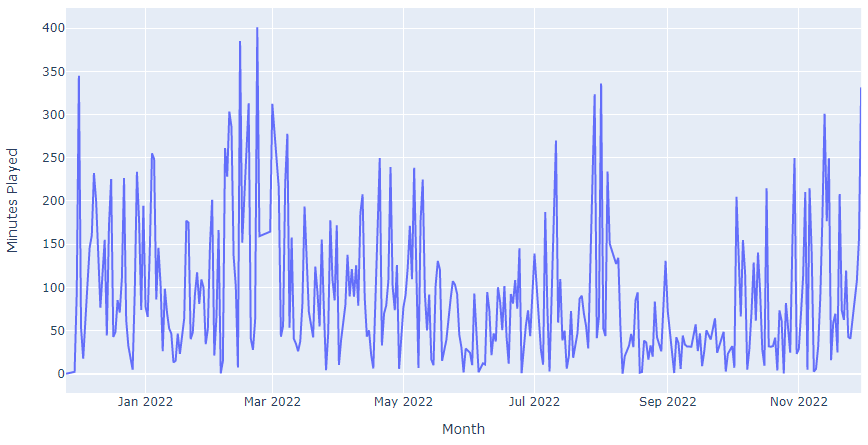

Did I listen to Spotify on more days than others?

In [19]:
minutes_by_day_week = streams.groupby(by=['day_week'], as_index=False).sum()

minutes_by_day_week

,day_week,minutes_played
0,Friday,4643.311583
1,Monday,5870.125783
2,Saturday,1820.775933
3,Sunday,2436.888833
4,Thursday,4451.323517
5,Tuesday,5628.632033
6,Wednesday,5901.959833


In [20]:
px.pie(minutes_by_day_week, names = 'day_week', values = 'minutes_played')

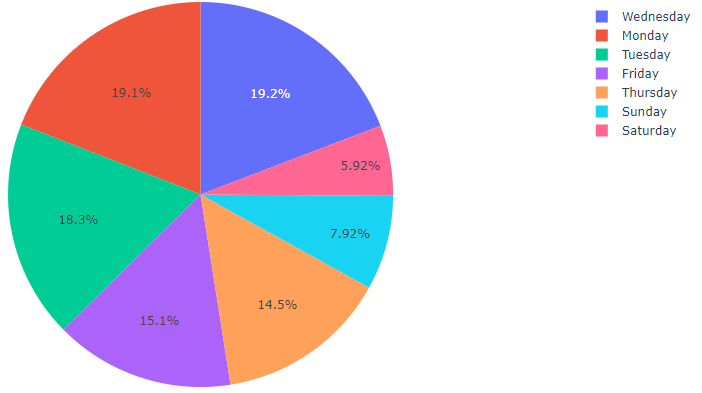

What about the total number of unique songs and total minutes played by each artist?

In [21]:
len(pd.unique(streams['artist_name'])) # unique count of artists

1664

In [22]:
artist_track = streams[['artist_name', 'track_name']].groupby(['artist_name'], as_index = False).nunique()
artist_track  = artist_track.rename(columns = {'track_name': 'unique_songs'})

artist_time = streams[['artist_name', 'minutes_played']].groupby(['artist_name'], as_index = False).sum()

In [23]:
top_artist = pd.merge(artist_track, artist_time, on = 'artist_name')
top_artist = top_artist.sort_values(by = 'unique_songs', ascending=False).head(10).reset_index(drop = True)

top_artist.head()

,artist_name,unique_songs,minutes_played
0,Mac Miller,136,1391.682317
1,My Favorite Murder with Karen Kilgariff and Ge...,100,4394.669617
2,$uicideboy$,72,1837.296083
3,blackbear,51,307.219917
4,"Tyler, The Creator",49,52.255733


In [24]:
px.scatter(top_artist, x = 'artist_name', y = 'minutes_played', size = 'unique_songs')

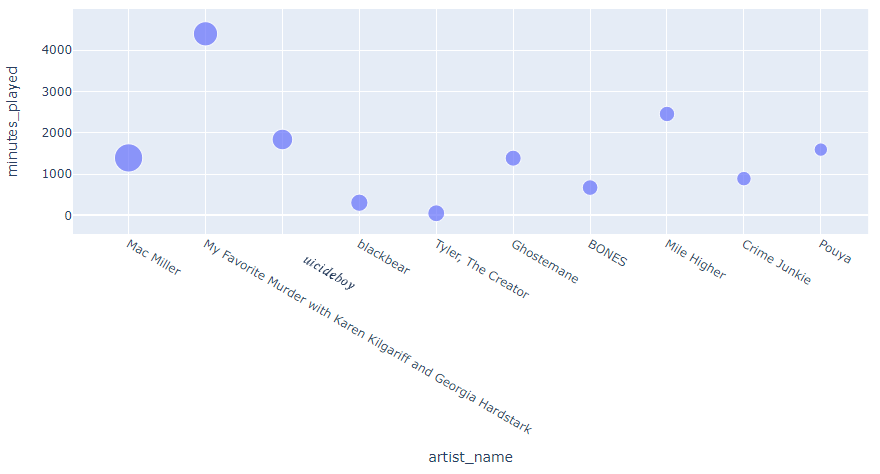

What were my most listened to songs by the sum of minutes played?

In [25]:
track = streams.groupby(['track_name'], as_index=False).sum().sort_values(by = 'minutes_played', ascending = False)
track_artist = streams[['artist_name', 'track_name']].drop_duplicates(subset = ["track_name"])
track = pd.merge(track_artist, track, on = 'track_name').sort_values(by = 'minutes_played', ascending = False).reset_index(drop = True).head(10) 

track.head()

,artist_name,track_name,minutes_played
0,Pouya,Void,292.336650
1,$uicideboy$,Materialism as a Means to an End,252.245083
2,Pouya,Stick Out,237.560517
3,$uicideboy$,Venom,218.923567
4,Mac Miller,The Spins,192.250333


In [28]:
ax = px.bar(track, x = 'track_name', y = 'minutes_played', color = "artist_name")
ax.update_layout(xaxis = {'categoryorder':'total descending'})

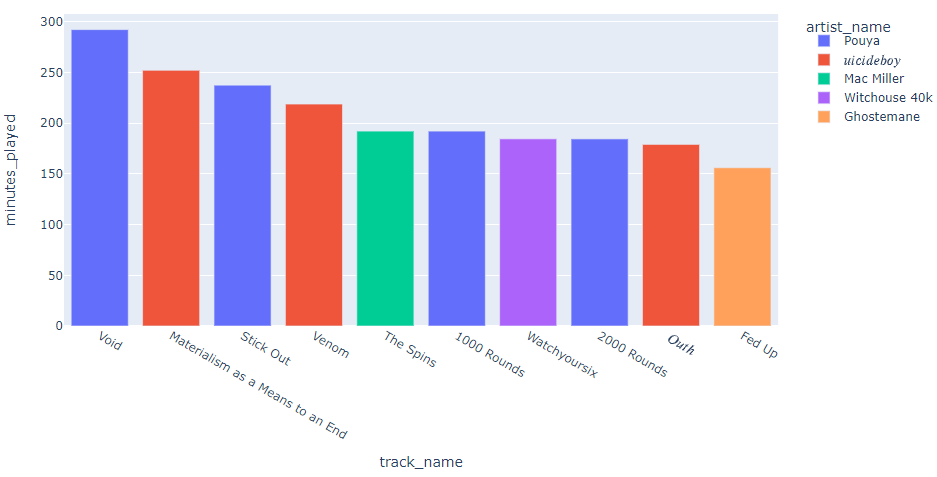

What is the average length that I listened to a song? And the average length for my most listened to songs?

With most songs being ~3 minutes long, as expected I have a difficult time listening to an extire song, even for my top songs!

In [29]:
round(streams['minutes_played'].mean(), 2)

1.07

In [30]:
round(streams[streams['track_name'].isin(track['track_name'])].groupby(['track_name'], as_index=False)['minutes_played'].mean(), 2)

,track_name,minutes_played
0,$Outh $Ide $Uicide,1.31
1,1000 Rounds,1.36
2,2000 Rounds,1.25
3,Fed Up,1.31
4,Materialism as a Means to an End,1.69
5,Stick Out,1.52
6,The Spins,1.40
7,Venom,1.49
8,Void,1.79
9,Watchyoursix,1.90


### Import Spotify's API Data

In this next section, I will use data from Spotify's API.

Prior to the code below, I created a developer account [here](https://developer.spotify.com/dashboard/). You do not need a Spotify Premium subscription, but will need a Spotify account to access this tool. The process to retrieve the data is a little complicated. [Steven Morse's post titled "Exploring the Spotify API in Python"](https://stmorse.github.io/journal/spotify-api.html) and [John Mannelly's blog post titled "How to Build Your Own Spotify Wrapped with Python, Spotipy and Glide Apps"](https://jman4190.medium.com/build-your-own-spotify-wrapped-with-python-spotify-and-glide-apps-493dc7da20b) were excellent resources I used to help me get the information needed. 

Part of the reason I chose this route was because the streaming data provided by Spotify (used in the section prior to this) only contained simple information like the artist's name, track name, and date. I was interested in getting a little more information about the music I listen to. 

#### Note: To gain access to Spotify's API data, two unique fields, `client_id` and `client_secret` were required. These are unique to me so to protect my privacy, these were redacted from the following code. Since the following would not run without these unique identifiers, I commented out the code and read in the final `.csv` for this section (see at end).

#### Album Information

In [ ]:
# import spotipy
# from spotipy.oauth2 import SpotifyOAuth
# import requests

Initiated the `sp` object.

In [ ]:
# sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id = '***'
#                                                , client_secret = '***'
#                                                , redirect_uri = 'http://localhost:9000'
#                                                , scope = 'user-top-read'))

Used `sp.current_user_top_tracks()` to get the top tracks for my account for the short, medium, and long terms. It was difficult to find information on what timeframe is used to categorize the tracks. To get a good understanding of my listening, I decided to use all available options.

Then created an empty list that will have the track `id` appended as the function loops over the dictionary. 


In [ ]:
# top_tracks_short = sp.current_user_top_tracks(limit = 100, offset  = 0, time_range = 'short_term')
# top_tracks_medium = sp.current_user_top_tracks(limit = 100, offset = 0, time_range = 'medium_term')
# top_tracks_long = sp.current_user_top_tracks(limit = 100, offset = 0, time_range = 'long_term')

# def get_track_ids(time_frame):
#     track_ids = []
#     for song in time_frame['items']:
#         track_ids.append(song['id'])
#     return track_ids

Applied the function and created one list of all the short, medium, and long term information.

In [ ]:
# track_ids_s = get_track_ids(top_tracks_short)
# track_ids_m = get_track_ids(top_tracks_medium)
# track_ids_l = get_track_ids(top_tracks_long)

# track_ids = track_ids_s + track_ids_m + track_ids_l
# len(track_ids) # checkpoint

Created a function to get the track features and all information in now in a DataFrame called `df_album`.

In [ ]:
# def get_track_features(id):
#     meta = sp.track(id)
#     name = meta['name']
#     album = meta['album']['name']
#     artist = meta['album']['artists'][0]['name']
#     track_uri = meta['id']
#     track_info = [track_uri, name, album, artist]
#     return track_info

In [ ]:
# tracks = []

# for i in range(len(track_ids)):
#     track2 = get_track_features(track_ids[i])
#     tracks.append(track2)

Converted the `tracks` list into a DataFrame called `df_album`.

In [ ]:
# df_album = pd.DataFrame(tracks, columns = ['track_uri', 'name', 'album', 'artist'])
# df_album = df_album.drop_duplicates().rename(columns={'name': 'track_name', 'artist': 'artist_name'}).sort_values(by = 'track_uri').reset_index(drop = True)

# df_album.head()

#### Genre Information

In [ ]:
# AUTH_URL = 'https://accounts.spotify.com/api/token'
# CLIENT_ID = '***'
# CLIENT_SECRET = '***'

# auth_response = requests.post(AUTH_URL, {
#     'grant_type': 'client_credentials',
#     'client_id': CLIENT_ID,
#     'client_secret': CLIENT_SECRET,
# })
# auth_response_data = auth_response.json()
# access_token = auth_response_data['access_token']

Created a blank dictionary called `dict_genre` that will have the `track_uri`, `artist_uri`, and `genre` appended to it.

In [ ]:
# BASE_URL = 'https://api.spotify.com/v1/'
# headers = {'Authorization': 'Bearer {token}'.format(token=access_token)}

# dict_genre = {}
# track_uris = track_ids

# for t_uri in track_uris:
#     dict_genre[t_uri] = {'artist_uri': "", "genres":[]}
#     r = requests.get(BASE_URL + 'tracks/' + t_uri, headers=headers)
#     r = r.json()
#     a_uri = r['artists'][0]['uri'].split(':')[2]
#     dict_genre[t_uri]['artist_uri'] = a_uri
#     s = requests.get(BASE_URL + 'artists/' + a_uri, headers=headers)
#     s = s.json()
#     dict_genre[t_uri]['genres'] = s['genres']

Converted the dictionary to a DataFrame called `df_genre`.

In [ ]:
# df_genre = pd.DataFrame.from_dict(dict_genre, orient='index')
# df_genre.insert(0, 'track_uri', df_genre.index)
# df_genre.reset_index(inplace=True, drop=True)

The `genres` column is in list format. Created columns for each potential item in the list, then used `.tolist()` to separate the list items.

In [ ]:
# df_genre[['genre1', 'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7']] = pd.DataFrame(df_genre.genres.tolist())
# df_genre = df_genre.drop(['genres'], axis=1).sort_values(by = 'track_uri').reset_index(drop = True)

# df_genre.head()

#### Audio Features Information

Performed a  similar process to get the audio features. Created a blank dictionary called `dict_feat` which will have the `track_uri` and `features` appended to it.

In [ ]:
# dict_feat = {}
# track_uris = track_ids

# for t_uri in track_uris:
#     dict_feat[t_uri] = {"features":[]}
#     f = requests.get(BASE_URL + 'audio-features/' + t_uri, headers=headers)
#     f = f.json()
#     dict_feat[t_uri]['features'] = f

In [ ]:
# df_feat = pd.DataFrame.from_dict(dict_feat, orient='index')
# df_feat.insert(0, 'track_uri', df_feat.index)
# df_feat.reset_index(inplace=True, drop=True)

# df_feat.head()

In [ ]:
# feat = df_feat['features'].apply(pd.Series)
# df_features = pd.concat([df_feat, feat], axis = 1)
# df_features = df_features.drop(['time_signature', 'analysis_url', 'track_href', 'uri', 'id', 'type', 'features'], axis = 1).sort_values(by = 'track_uri').reset_index(drop = True)

# df_features.head()

#### Combining the Album, Genre, and Audio Features Together

Created a DataFrame called `api_features` that is a combination of `df_genre`, `df_album`, and `df_features`.

In [ ]:
# pd.set_option('display.max_columns', None)

# api_features = pd.concat([df_genre, df_album, df_features], axis = 1, sort=False)

# api_features.head()

In [31]:
api_features = pd.read_csv('api_features.csv')  

api_features.head()

,Unnamed: 0,track_uri,artist_uri,genre1,genre2,genre3,genre4,genre5,genre6,genre7,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0,06DZwL9QE5wTRdtxVbxJrL,2kCO8LXN1usaOPL3iEE28I,modern indie pop,pop,NaN,NaN,NaN,NaN,NaN,...,6,-9.186,1,0.1110,0.65200,0.000000,0.165,0.4950,122.141,173733
1,1,07HPV6hzecJmMJwsIX8YVU,7nU4hB040gTmHm45YYMvqc,dance pop,pop,post-teen pop,NaN,NaN,NaN,NaN,...,4,-3.975,1,0.0320,0.00154,0.000000,0.433,0.6430,125.988,180800
2,2,097EO64tc1lsVaewUoRXIS,4qBgvVog0wzW75IQ48mU7v,pop,pop rap,rap,viral rap,NaN,NaN,NaN,...,0,-4.284,1,0.2940,0.17300,0.000000,0.234,0.4810,109.941,258769
3,3,0AQXOzjEG2ofwGrDyqUY7H,3uL4UpqShC4p2x1dJutoRW,dark trap,florida rap,NaN,NaN,NaN,NaN,NaN,...,10,-5.438,0,0.0947,0.11000,0.000023,0.120,0.1910,120.098,183937
4,4,0BV0AYGLVlu2SdjN3J9twp,3uL4UpqShC4p2x1dJutoRW,dark trap,florida rap,NaN,NaN,NaN,NaN,NaN,...,8,-7.498,1,0.2560,0.49900,0.695000,0.147,0.0684,115.058,151625


### API Data Analysis

What genres did I listen to most?

In [32]:
top_genre = pd.concat([api_features['genre1'], api_features['genre2'], api_features['genre3'], api_features['genre4'], api_features['genre5'], api_features['genre6'], api_features['genre7']])
top_genre = top_genre.value_counts().rename_axis('genre').reset_index(name = 'counts').head(10)

top_genre.head()

,genre,counts
0,rap,29
1,dark trap,25
2,viral rap,22
3,pop,20
4,hip hop,18


In [33]:
px.bar(top_genre, x = 'genre', y = 'counts', color = 'genre')

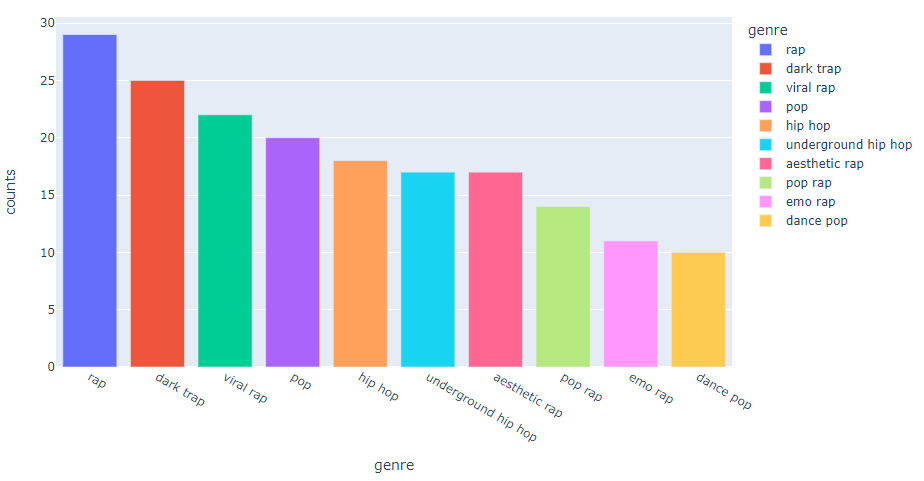

Using the most listened to songs from my streaming history, filtered `api_features` where the `track_name` is in my previously defined top songs list. 

According to the [Spotify Developer documentation](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features), the features are described as below:

    - acousticness - A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 
    - danceability - How suitable a track is for dancing.
    - energy - Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. 
    - instrumentalness - Predicts whether a track contains no vocals. 
    - liveness - Detects the presence of an audience in the recording. 
    - loudness - The overall loudness of a track in decibels (dB).
    - speechiness - Speechiness detects the presence of spoken words in a track. 
    - tempo - The overall estimated tempo of a track in beats per minute (BPM). 
    - valence - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track.

In [34]:
top_track_features = api_features[['track_name', 'artist_name', 'genre1', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']][api_features['track_name'].isin(track['track_name'])].reset_index(drop = True)

top_track_features.head()

,track_name,artist_name,genre1,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Fed Up,Ghostemane,dark trap,0.849,0.758,-7.498,0.2560,0.49900,0.695000,0.1470,0.0684,115.058
1,Stick Out,Pouya,aesthetic rap,0.770,0.853,-3.849,0.2210,0.00420,0.000961,0.0936,0.6150,164.037
2,Watchyoursix,Witchouse 40k,dark trap,0.834,0.464,-10.932,0.1950,0.15500,0.008930,0.1480,0.3670,128.023
3,$Outh $Ide $Uicide,$uicideboy$,dark trap,0.797,0.516,-6.286,0.0832,0.00538,0.438000,0.0728,0.0478,109.993
4,Void,Pouya,aesthetic rap,0.767,0.854,-4.570,0.0675,0.16900,0.000529,0.1750,0.5190,109.943


How do the audio features look in box plots?

(array([1, 2, 3, 4, 5, 6, 7]),
 [Text(1, 0, 'acousticness'),
  Text(2, 0, 'danceability'),
  Text(3, 0, 'energy'),
  Text(4, 0, 'instrumentalness'),
  Text(5, 0, 'liveness'),
  Text(6, 0, 'speechiness'),
  Text(7, 0, 'valence')])

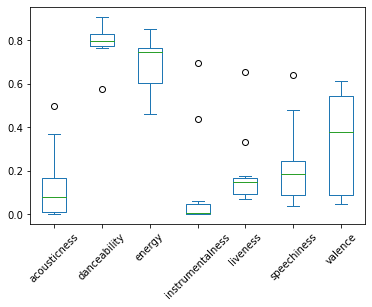

In [35]:
from matplotlib import pyplot as plt

top_track_features[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']].plot(kind = 'box')

plt.xticks(rotation = 45)

Some features I was particularly interested in were danceability, energy, and valance so I created classes for which half of the spectrum the values were in. Turns out this did not have many purpose because all songs had the same values for each, except one song had a different valence value. 

Looks like I liked high dance, high energy, and positive valence songs!

In [36]:
def dance_class(danceability):
    if danceability > 0.05:
        d = 'High'
    elif danceability < 0.5:
        d = 'Low'
    else:
        d = 'N/A'
    return d
    
top_track_features['danceability_class'] = top_track_features['danceability'].apply(dance_class)

def energy_class(energy):
    if energy > 0.05:
        e = 'High'
    elif energy < 0.5:
        e = 'Low'
    else:
        e = 'N/A'
    return e
    
top_track_features['energy_class'] = top_track_features['energy'].apply(energy_class)

def valence_class(valence):
    if valence > 0.05:
        v = 'Positive'
    elif valence < 0.5:
        v ='Negative'
    else:
        v = 'N/A'
    return v
    
top_track_features['valence_class'] = top_track_features['valence'].apply(valence_class)

top_track_features[['track_name', 'artist_name', 'danceability_class', 'energy_class', 'valence_class']]

,track_name,artist_name,danceability_class,energy_class,valence_class
0,Fed Up,Ghostemane,High,High,Positive
1,Stick Out,Pouya,High,High,Positive
2,Watchyoursix,Witchouse 40k,High,High,Positive
3,$Outh $Ide $Uicide,$uicideboy$,High,High,Negative
4,Void,Pouya,High,High,Positive
5,Materialism as a Means to an End,$uicideboy$,High,High,Positive
6,The Spins,Mac Miller,High,High,Positive
7,1000 Rounds,Pouya,High,High,Positive
8,2000 Rounds,Pouya,High,High,Positive
9,Venom,Ghostemane,High,High,Positive


What would the features of my ideal song be?

In [37]:
top_track_features[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].mean()

danceability          0.791200
energy                0.697500
loudness             -6.165000
speechiness           0.226340
acousticness          0.139138
instrumentalness      0.122292
liveness              0.195880
valence               0.334100
tempo               136.170900
dtype: float64

Is there a correlation between genre and any of the audio features?

No, there was no significant correlation between genre 1 and any of the audio features. This was surprising to me. I thought, for example, if the genre was rap, then speechiness would be high. This was not the case, however, the following pairs of values did have the top 3 significant positive correlations. 

- danceability & liveness
- valence & track_name
- energy & loudness

In [38]:
top_track_features = api_features[['track_name', 'artist_name', 'genre1', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']][api_features['track_name'].isin(track['track_name'])].reset_index(drop = True)

top_track_features.corr()

num_top_track_features = top_track_features

for col_name in num_top_track_features.columns:
    if (num_top_track_features[col_name].dtype == 'object'):
        num_top_track_features[col_name] = num_top_track_features[col_name].astype('category')
        num_top_track_features[col_name] = num_top_track_features[col_name].cat.codes
        
num_top_track_features.corr()

,track_name,artist_name,genre1,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
track_name,1.000000,0.415199,0.190305,0.297826,-0.036919,-0.240326,-0.233723,-0.088140,-0.467911,0.214454,0.685551,-0.072933
artist_name,0.415199,1.000000,-0.465620,-0.295610,0.144182,-0.070943,-0.055778,0.029947,-0.487542,-0.114362,0.147826,0.031830
genre1,0.190305,-0.465620,1.000000,0.435668,-0.365800,-0.207898,-0.269580,-0.120411,0.205151,-0.032576,0.138328,-0.255513
danceability,0.297826,-0.295610,0.435668,1.000000,-0.244894,-0.286281,-0.636461,-0.331553,0.171526,0.551185,0.184790,-0.124621
energy,-0.036919,0.144182,-0.365800,-0.244894,1.000000,0.766942,0.009661,0.099347,-0.139913,-0.212880,0.387469,0.230341
loudness,-0.240326,-0.070943,-0.207898,-0.286281,0.766942,1.000000,-0.169053,-0.332675,-0.224131,-0.134608,0.324884,0.176669
speechiness,-0.233723,-0.055778,-0.269580,-0.636461,0.009661,-0.169053,1.000000,0.548702,-0.045084,-0.144420,-0.193083,0.501602
acousticness,-0.088140,0.029947,-0.120411,-0.331553,0.099347,-0.332675,0.548702,1.000000,0.543241,-0.227268,-0.469254,-0.262663
instrumentalness,-0.467911,-0.487542,0.205151,0.171526,-0.139913,-0.224131,-0.045084,0.543241,1.000000,-0.220999,-0.653556,-0.547317
liveness,0.214454,-0.114362,-0.032576,0.551185,-0.212880,-0.134608,-0.144420,-0.227268,-0.220999,1.000000,0.022578,0.209963


Text(113.09375, 0.5, 'Track Features')

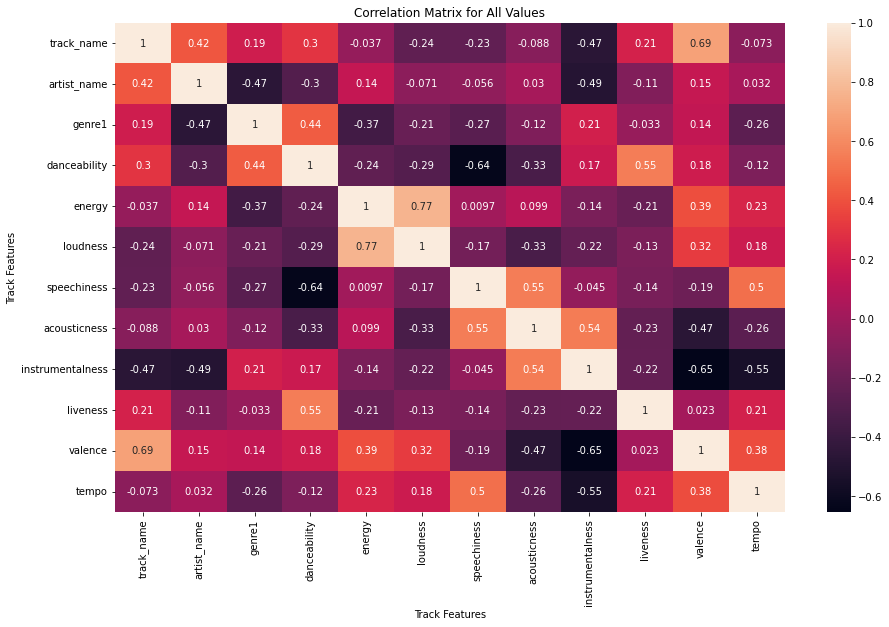

In [39]:
import seaborn as sns

correlation_matrix = correlation_matrix = num_top_track_features.corr()
plt.figure(figsize=(15, 9))

sns.heatmap(correlation_matrix, annot = True)

plt.title('Correlation Matrix for All Values')

plt.xlabel('Track Features')
plt.ylabel('Track Features')#.corr()

In [40]:
corr_pairs = correlation_matrix.unstack().sort_values()

pd.set_option('display.max_rows', None)

high_corr = corr_pairs[(corr_pairs) > 0.5]

high_corr

tempo             speechiness         0.501602
speechiness       tempo               0.501602
acousticness      instrumentalness    0.543241
instrumentalness  acousticness        0.543241
speechiness       acousticness        0.548702
acousticness      speechiness         0.548702
danceability      liveness            0.551185
liveness          danceability        0.551185
valence           track_name          0.685551
track_name        valence             0.685551
energy            loudness            0.766942
loudness          energy              0.766942
track_name        track_name          1.000000
liveness          liveness            1.000000
instrumentalness  instrumentalness    1.000000
acousticness      acousticness        1.000000
speechiness       speechiness         1.000000
loudness          loudness            1.000000
energy            energy              1.000000
danceability      danceability        1.000000
genre1            genre1              1.000000
artist_name  

### Dashboard Visualization

Wrote objects to `.csv` files to use in a Tableau dashboard.

Check out my [DIY Spotify Wrapped 2022](https://public.tableau.com/views/WIPSpotifyWrapped/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link) dashboard on Tableau Public!

In [ ]:
streams.to_csv('streams.csv')
api_features.to_csv('api_features.csv')

### Conclusion

Looking at my Spotify streaming history from the last year, I really liked listening to Mac Miller, Suicideboys, and Pouya for tracks,  while My Favorite Murder and Mile Higher were my top podcasts. “Void” and “Materialism as a Means to an End” were my most listening to tracks. I was not surprised to see that most of my listening occurred on weekdays. 

Comparing my analysis to what was provided to me in the Spotify application, their top artists, top songs, etc. all matched mine. 

However,  I was surprised to see that rap and dark rap were my most listened to genres. You may be looking at this analysis and thinking I have a dedicated taste in music. I promise this has not always been the case. It would be interesting to see how 2022 compares to prior years. Maybe this will be my next project. :)